In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/10-715/HW6
!mkdir -p ./results ./plots ./models

/content/drive/MyDrive/10-715/HW6


In [ ]:
%matplotlib inline

import time
import numpy as np
import matplotlib.pyplot as plt
import torch as t
from torch import nn
from torch import optim
from torch.nn import functional as F
import torchvision
import torchvision.transforms as transforms
import pickle
import itertools


def divide_no_nan(a, b):
    """
    a/b where the resulted NaN or Inf are replaced by 0.
    """
    result = a / b
    result[result != result] = .0
    result[result == np.inf] = .0
    return result


class WeightNormConstrainer(object):
    def __init__(self, norm):
      self.norm = norm

    def __call__(self, module):
      if hasattr(module, 'weight'):
          w = module.weight.data
          wn = t.norm(w, p=2, dim=1).detach()
          ind = t.gt(wn, self.norm)
          div = (divide_no_nan(wn, self.norm) * ind) + (1 * t.logical_not(ind))
          div = div.unsqueeze_(1)
          w.div_(div)

class _LeNet(nn.Module):
    def __init__(self, layers):
      super(_LeNet, self).__init__()
      self.input_layer = nn.Sequential(*layers['input_layer'])
      self.hidden_layers = nn.Sequential(*layers['hidden_layers'])
      self.output_layer = nn.Sequential(*layers['output_layer'])
      self.activation = {}

    def layer_features(self, x):
      input_layer = self.input_layer(x)
      hidden = self.hidden_layers(input_layer)
      logits = self.output_layer(hidden)
      layer_features = {'input_layer': input_layer.data.cpu().numpy(),
                        'hidden': hidden.data.cpu().numpy(),
                        'logits': logits.data.cpu().numpy()}
      return layer_features
    
    def get_activation(self, name):
        def hook(model, input, output):
            self.activation[name] = output.detach().cpu().numpy()
        return hook

    def get_intermediate(self, x): 
        #TODO: complete this function to return the outputs of first conv and first pooling layer - Done
        # Returns the output as a numpy aray for ease of plotting it later
        self.input_layer[1].register_forward_hook(self.get_activation('conv1'))
        pool1_out = self.input_layer(x)  
        return self.activation['conv1'], pool1_out.detach().cpu().numpy()
    def forward(self, x):
      input_layer = self.input_layer(x)
      hidden = self.hidden_layers(input_layer)
      logits = self.output_layer(hidden)
      return logits

# We recommend you make this modules as the first component of your input layers 
class Reshape(t.nn.Module):
    def forward(self, x):
      return x.view(-1,3,32,32)

class LeNet(object):
    def __init__(self, params, use_custom=False):
        super().__init__()
        self.params = params
        self.device = t.device('cuda' if t.cuda.is_available() else 'cpu')
        self.activations = {'logistic': nn.Sigmoid(), 'relu': nn.ReLU()}
        self.pooling = {'avg':nn.AvgPool2d(kernel_size=2, stride=2),'max':nn.MaxPool2d(kernel_size=2, stride=2)}
        # Instantiate model
        t.manual_seed(self.params['random_seed'])
        np.random.seed(self.params['random_seed'])
        layers = self._initialize_network() if not use_custom else self._initialize_network_custom()
        self.model = _LeNet(layers).to(self.device)

    def _initialize_network(self):
        # TODO: complete this function - Done
        # You may have to use Reshape() and nn.Flatten()
        # The architecture may be slightly different with no pooling
        if self.params['pooling'] != 'no':
            input_layers = [
                Reshape(),
                nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=0),
                self.activations[self.params['activation']],
                self.pooling[self.params['pooling']]
            ]
            hidden_layers = [
                nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
                self.activations[self.params['activation']],
                self.pooling[self.params['pooling']],
                # nn.Conv2d(16, 120, kernel_size=5, stride=1, padding=0),
                # self.activations[self.params['activation']],
                nn.Flatten(),
                nn.Linear(400, 120),
                self.activations[self.params['activation']],
                nn.Linear(120, 84),
                self.activations[self.params['activation']]
            ]
            output_layer = [
                nn.Linear(84, 10)
            ]
        else:
            input_layers = [
                Reshape(),
                nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=0),
                self.activations[self.params['activation']]
            ]
            hidden_layers = [
                nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
                self.activations[self.params['activation']],
                # nn.Conv2d(16, 120, kernel_size=5, stride=1, padding=0),
                # self.activations[self.params['activation']],
                nn.Flatten(),
                nn.Linear(9216, 120),
                self.activations[self.params['activation']],
                nn.Linear(120, 84),
                self.activations[self.params['activation']]
            ]
            output_layer = [
                nn.Linear(84, 10)
            ]
        layers = {'input_layer': input_layers,
          'hidden_layers': hidden_layers,
          'output_layer': output_layer}
        return layers
    
    def _initialize_network_custom(self):
        # Custom CNN network
        assert self.params['pooling'] != 'no'

        input_layers = [
            Reshape(),
            nn.Conv2d(3, 8, kernel_size=5, stride=1, padding='same'),
            self.activations[self.params['activation']],
            self.pooling[self.params['pooling']]
        ]
        hidden_layers = [
            nn.Conv2d(8, 16, kernel_size=5, stride=1, padding='same'),
            self.activations[self.params['activation']],
            self.pooling[self.params['pooling']],
            nn.Conv2d(16, 64, kernel_size=3, stride=1, padding='same'),
            self.activations[self.params['activation']],
            self.pooling[self.params['pooling']],
            nn.Conv2d(64, 128, kernel_size=4, stride=1, padding=0),
            self.activations[self.params['activation']],
            nn.Flatten(),
            nn.Linear(128, 80),
            self.activations[self.params['activation']]
        ]
        output_layer = [
            nn.Linear(80, 10)
        ]

        layers = {'input_layer': input_layers,
          'hidden_layers': hidden_layers,
          'output_layer': output_layer}
        return layers


    def evaluate_accuracy(self, dataloader):
        self.model.eval()
        with t.no_grad():
            n_correct = 0
            n_samples = 0
            for batch in iter(dataloader):
                batch_x = t.flatten(batch[0].to(self.device), start_dim=1)
                batch_y = batch[1].to(self.device)
                logits = self.model(batch_x)
                y_hat = t.argmax(logits, dim=1)
                correct = t.sum(y_hat==batch_y)
                n_correct += correct.data.cpu().numpy()
                n_samples += len(batch_x)
        accuracy = (n_correct/n_samples) * 100
        self.model.train()
        return accuracy

    def evaluate_cross_entropy(self, dataloader):
        self.model.eval()
        loss_func = nn.CrossEntropyLoss()        
        with t.no_grad():
            n_samples = 0
            total_loss = 0
            for batch in iter(dataloader):
                pass
                # TODO: Write the code to measure the cross_entropy 
                # (Hint, look at the evaluate_accuracy method)
                # Be careful with the eval and train modes of the model
                # This should be same as HW5 - Done
                batch_x = t.flatten(batch[0].to(self.device), start_dim=1)
                batch_y = batch[1].to(self.device)
                
                logits = self.model(batch_x)
                loss = loss_func(logits, batch_y) 
                
                total_loss += loss.item() * len(batch_x)
                n_samples += len(batch_x)
        
        cross_entropy = total_loss/n_samples

        self.model.train()

        return cross_entropy

    def adjust_lr(self, optimizer, lr_decay):
        for param_group in optimizer.param_groups:
            param_group['lr'] = param_group['lr'] * lr_decay

    def adjust_momentum(self, optimizer, step, momentum_change_steps,
                        initial_momentum, final_momentum):
        mcs = momentum_change_steps
        s = min(step, mcs)
        momentum = (initial_momentum) * ((mcs-s)/mcs) + \
                   (final_momentum) * (s/mcs)
        for param_group in optimizer.param_groups:
            param_group['momentum'] = momentum

    def save_weights(self, path):
        t.save(self.model.state_dict(), path)

    def load_weights(self, path):
        self.model.load_state_dict(t.load(path,
                                          map_location=t.device(self.device)))
        self.model.eval()

    def fit(self, insample_dataloader, outsample_dataloader):        
        # Instantiate optimization tools
        loss = nn.CrossEntropyLoss()        
        optimizer = optim.SGD([{'params': self.model.input_layer.parameters()},
                               {'params': self.model.hidden_layers.parameters()},
                               {'params': self.model.output_layer.parameters(),
                                'weight_decay': self.params['output_l2_decay']}],
                               lr=self.params['initial_lr'],
                               momentum=self.params['initial_momentum'])
        
        constrainer = WeightNormConstrainer(norm=self.params['weight_norm'])
        # Initialize counters and trajectories
        step = 0
        epoch = 0
        metric_trajectories = {'step':  [],
                               'epoch':  [],
                               'insample_accuracy': [],
                               'outsample_accuracy': [],
                               'insample_cross_entropy': [],
                               'outsample_cross_entropy': []
                               }

        print('\n'+'='*36+f' Fitting LeNet ({self.params["pooling"]} pooling) '+'='*36)
        while step <= self.params['iterations']:

            # Train
            epoch += 1
            start_time = time.time()
            self.model.train()
            for batch in iter(insample_dataloader):
                step+=1
                if step > self.params['iterations']:
                    continue
                                
                batch_x = t.flatten(batch[0].to(self.device), start_dim=1)
                batch_y = batch[1].to(self.device)
                
                optimizer.zero_grad()

                # TODO: make predictions, compute the cross entropy loss and perform backward propagation
                # This should be same as HW5 - Done
                logits = self.model(batch_x)
                cross_entropy = loss(logits, batch_y) 
                cross_entropy.backward()

                t.nn.utils.clip_grad_norm_(self.model.parameters(), 20)
                optimizer.step()

                # Evaluate metrics
                if (step % self.params['display_step'] == 0):
                    in_cross_entropy   = self.evaluate_cross_entropy(insample_dataloader)
                    out_cross_entropy  = self.evaluate_cross_entropy(outsample_dataloader)
                    in_accuracy        = self.evaluate_accuracy(insample_dataloader)
                    out_accuracy       = self.evaluate_accuracy(outsample_dataloader)

                    print('Epoch:', '%d,' % epoch,
                          'Step:', '%d,' % step,
                          'In Loss: {:.7f},'.format(in_cross_entropy),
                          'Out Loss: {:.7f},'.format(out_cross_entropy),
                          'In Acc: {:03.3f},'.format(in_accuracy),
                          'Out Acc: {:03.3f}'.format(out_accuracy))
                    
                    metric_trajectories['insample_cross_entropy'].append(in_cross_entropy)
                    metric_trajectories['outsample_cross_entropy'].append(out_cross_entropy)
                    metric_trajectories['insample_accuracy'].append(in_accuracy)
                    metric_trajectories['outsample_accuracy'].append(out_accuracy)
                    metric_trajectories['step'].append(step)
                    metric_trajectories['epoch'].append(epoch)

                # Update optimizer learning rate
                if step % self.params['adjust_lr_step'] == 0:
                    self.adjust_lr(optimizer=optimizer, lr_decay=self.params['lr_decay'])
                
                # Update optimizer momentum
                if step % self.params['adjust_momentum_step'] == 0 and \
                    step < self.params['momentum_change_steps']:
                    self.adjust_momentum(optimizer=optimizer, step=step,
                                         momentum_change_steps=self.params['momentum_change_steps'],
                                         initial_momentum=self.params['initial_momentum'],
                                         final_momentum=self.params['final_momentum'])
              
                # Constraint max_norm of weights
                if self.params['apply_weight_norm'] and \
                  (step % self.params['adjust_norm_step'] == 0):
                    self.model.apply(constrainer)
            
            print(f"Time elapsed for epoch {epoch}: {time.time()-start_time} seconds")

        # Store trajectories
        print('\n'+'='*35+' Finished Train '+'='*35)
        self.trajectories = metric_trajectories


def main(POOLING, custom=False): 
    params = {'model': 'lenet',
          'display_step': 250, 
          'batch_size': 256,
          'iterations': 3000, # 3000 or 500 
          'initial_lr': 0.05, 
          'lr_decay': 0.5,
          'adjust_lr_step': 1000,
          'initial_momentum': 0.9,
          'final_momentum': 0.95,
          'momentum_change_steps': 5_000,
          'adjust_momentum_step': 2_000,
          'apply_weight_norm': True,
          'weight_norm': 3.5,
          'adjust_norm_step': 1_000,
          'output_l2_decay': 0.001,
          'pooling': POOLING, # TODO try three options: 'max', 'avg','no' 
          'activation':'relu',
          'random_seed': 0}

    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    insample_dataloader = t.utils.data.DataLoader(trainset, batch_size=params['batch_size'], shuffle=True)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    outsample_dataloader = t.utils.data.DataLoader(testset, batch_size=params['batch_size'], shuffle=False)

    clf = LeNet(params, custom)

    t0 = time.time()
    clf.fit(insample_dataloader, outsample_dataloader)
    print(f"Total time elapsed for training: {time.time()-t0} seconds")

    # TODO: save trajectories and/or plot trajectories, final accuracy, and time elapsed - Done
    # TODO: plot the intermediate outputs using get_intermediate in _LeNet
    # To avoid unnecesary pain, saving classifier weights
    if not custom:
        clf.save_weights(f'./models/model_{POOLING}.pth')
        clf.load_weights(f'./models/model_{POOLING}.pth')

        with open(f'./results/results_{POOLING}.pkl', 'wb') as file:
            pickle.dump(clf.trajectories, file)
    
        # Pick one sample from the training set (so that its easier to explain what the model is learning)
        index = 1
        batch_x, batch_y = next(itertools.islice(iter(insample_dataloader), index, None))
        sample_x, sample_y = t.flatten(batch_x[:1].to(clf.device), start_dim=1), batch_y[0].item()
        conv1_out, pool1_out = clf.model.get_intermediate(sample_x)
        sample_x = sample_x.detach().cpu().numpy()
        intermediates = {
            'input': sample_x,
            'label': sample_y,
            'conv1': conv1_out,
            'pool1': pool1_out
        }

        with open(f'./results/visualize_{POOLING}.pkl', 'wb') as file:
            pickle.dump(intermediates, file)
    
    del clf
    
if __name__ == '__main__':
    for POOLING in ['max']:
        main(POOLING, True) # The second argument is True to train custom architecture; False for training LeNet arhcitecture

Files already downloaded and verified
Files already downloaded and verified

==================================== Fitting LeNet (max pooling) ====================================
Time elapsed for epoch 1: 11.68584942817688 seconds
Epoch: 2, Step: 250, In Loss: 1.4588238, Out Loss: 1.4721463, In Acc: 46.472, Out Acc: 45.320
Time elapsed for epoch 2: 39.79315733909607 seconds
Epoch: 3, Step: 500, In Loss: 1.1255225, Out Loss: 1.1775263, In Acc: 59.568, Out Acc: 57.550
Time elapsed for epoch 3: 39.64755201339722 seconds
Epoch: 4, Step: 750, In Loss: 0.8790379, Out Loss: 1.0075452, In Acc: 69.068, Out Acc: 65.030
Time elapsed for epoch 4: 41.23779249191284 seconds
Time elapsed for epoch 5: 11.54802417755127 seconds
Epoch: 6, Step: 1000, In Loss: 0.8138104, Out Loss: 1.0071698, In Acc: 71.368, Out Acc: 65.820
Time elapsed for epoch 6: 39.50590515136719 seconds
Epoch: 7, Step: 1250, In Loss: 0.6212802, Out Loss: 0.9209108, In Acc: 78.378, Out Acc: 69.030
Time elapsed for epoch 7: 39.64307260

In [ ]:
import gc
import torch

# Code to clear any memory trace left by previous models to get proper training times
gc.collect()
with torch.no_grad():
    torch.cuda.empty_cache()

In [ ]:
%matplotlib inline
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from google.colab import files

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

# Function to plot the accuracy and loss graphs for the three configurations of LeNet
def plot():
    trajectories = []
    config = ['max', 'avg', 'no']
    for POOLING in config:
        with open(f'./results/results_{POOLING}.pkl', 'rb') as file:
            trajectories.append(pickle.load(file))
    
    idx = 0
    def plot_trajectory(trajectory_name):
        nonlocal idx, trajectories, config
        plot_name = 'Loss' if trajectory_name == 'cross_entropy' else 'Accuracy'
        gs = gridspec.GridSpec(4, 4)
        m = 0

        plt.figure(idx, figsize = (8,6))
        for i in range(0, 4, 2):
            for j in range(0, 4, 2):
                if m == 3:
                    break
                if m < 2:
                    ax = plt.subplot(gs[i:i+2, j:j+2])
                else:
                    ax = plt.subplot(gs[i:i+2, 1:3])

                ax.plot(trajectories[m]['step'], trajectories[m][f'insample_{trajectory_name}'], linestyle='-.', color='b', label=f'Train {plot_name}')
                ax.plot(trajectories[m]['step'], trajectories[m][f'outsample_{trajectory_name}'], linestyle='-', color='orange', label=f'Test {plot_name}')
                ax.set_ylabel(plot_name)
                ax.set_xlabel('Gradient Step')
                ax.set_title(f'{config[m].upper()} pooling')
                ax.legend(loc='best')

                m+=1

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.suptitle(f'{plot_name} vs Gradient Steps')
        plt.savefig(f'./plots/{plot_name}.png')
        plt.show()
        files.download(f'./plots/{plot_name}.png')
        idx += 1
    
    plot_trajectory('cross_entropy')
    plot_trajectory('accuracy')


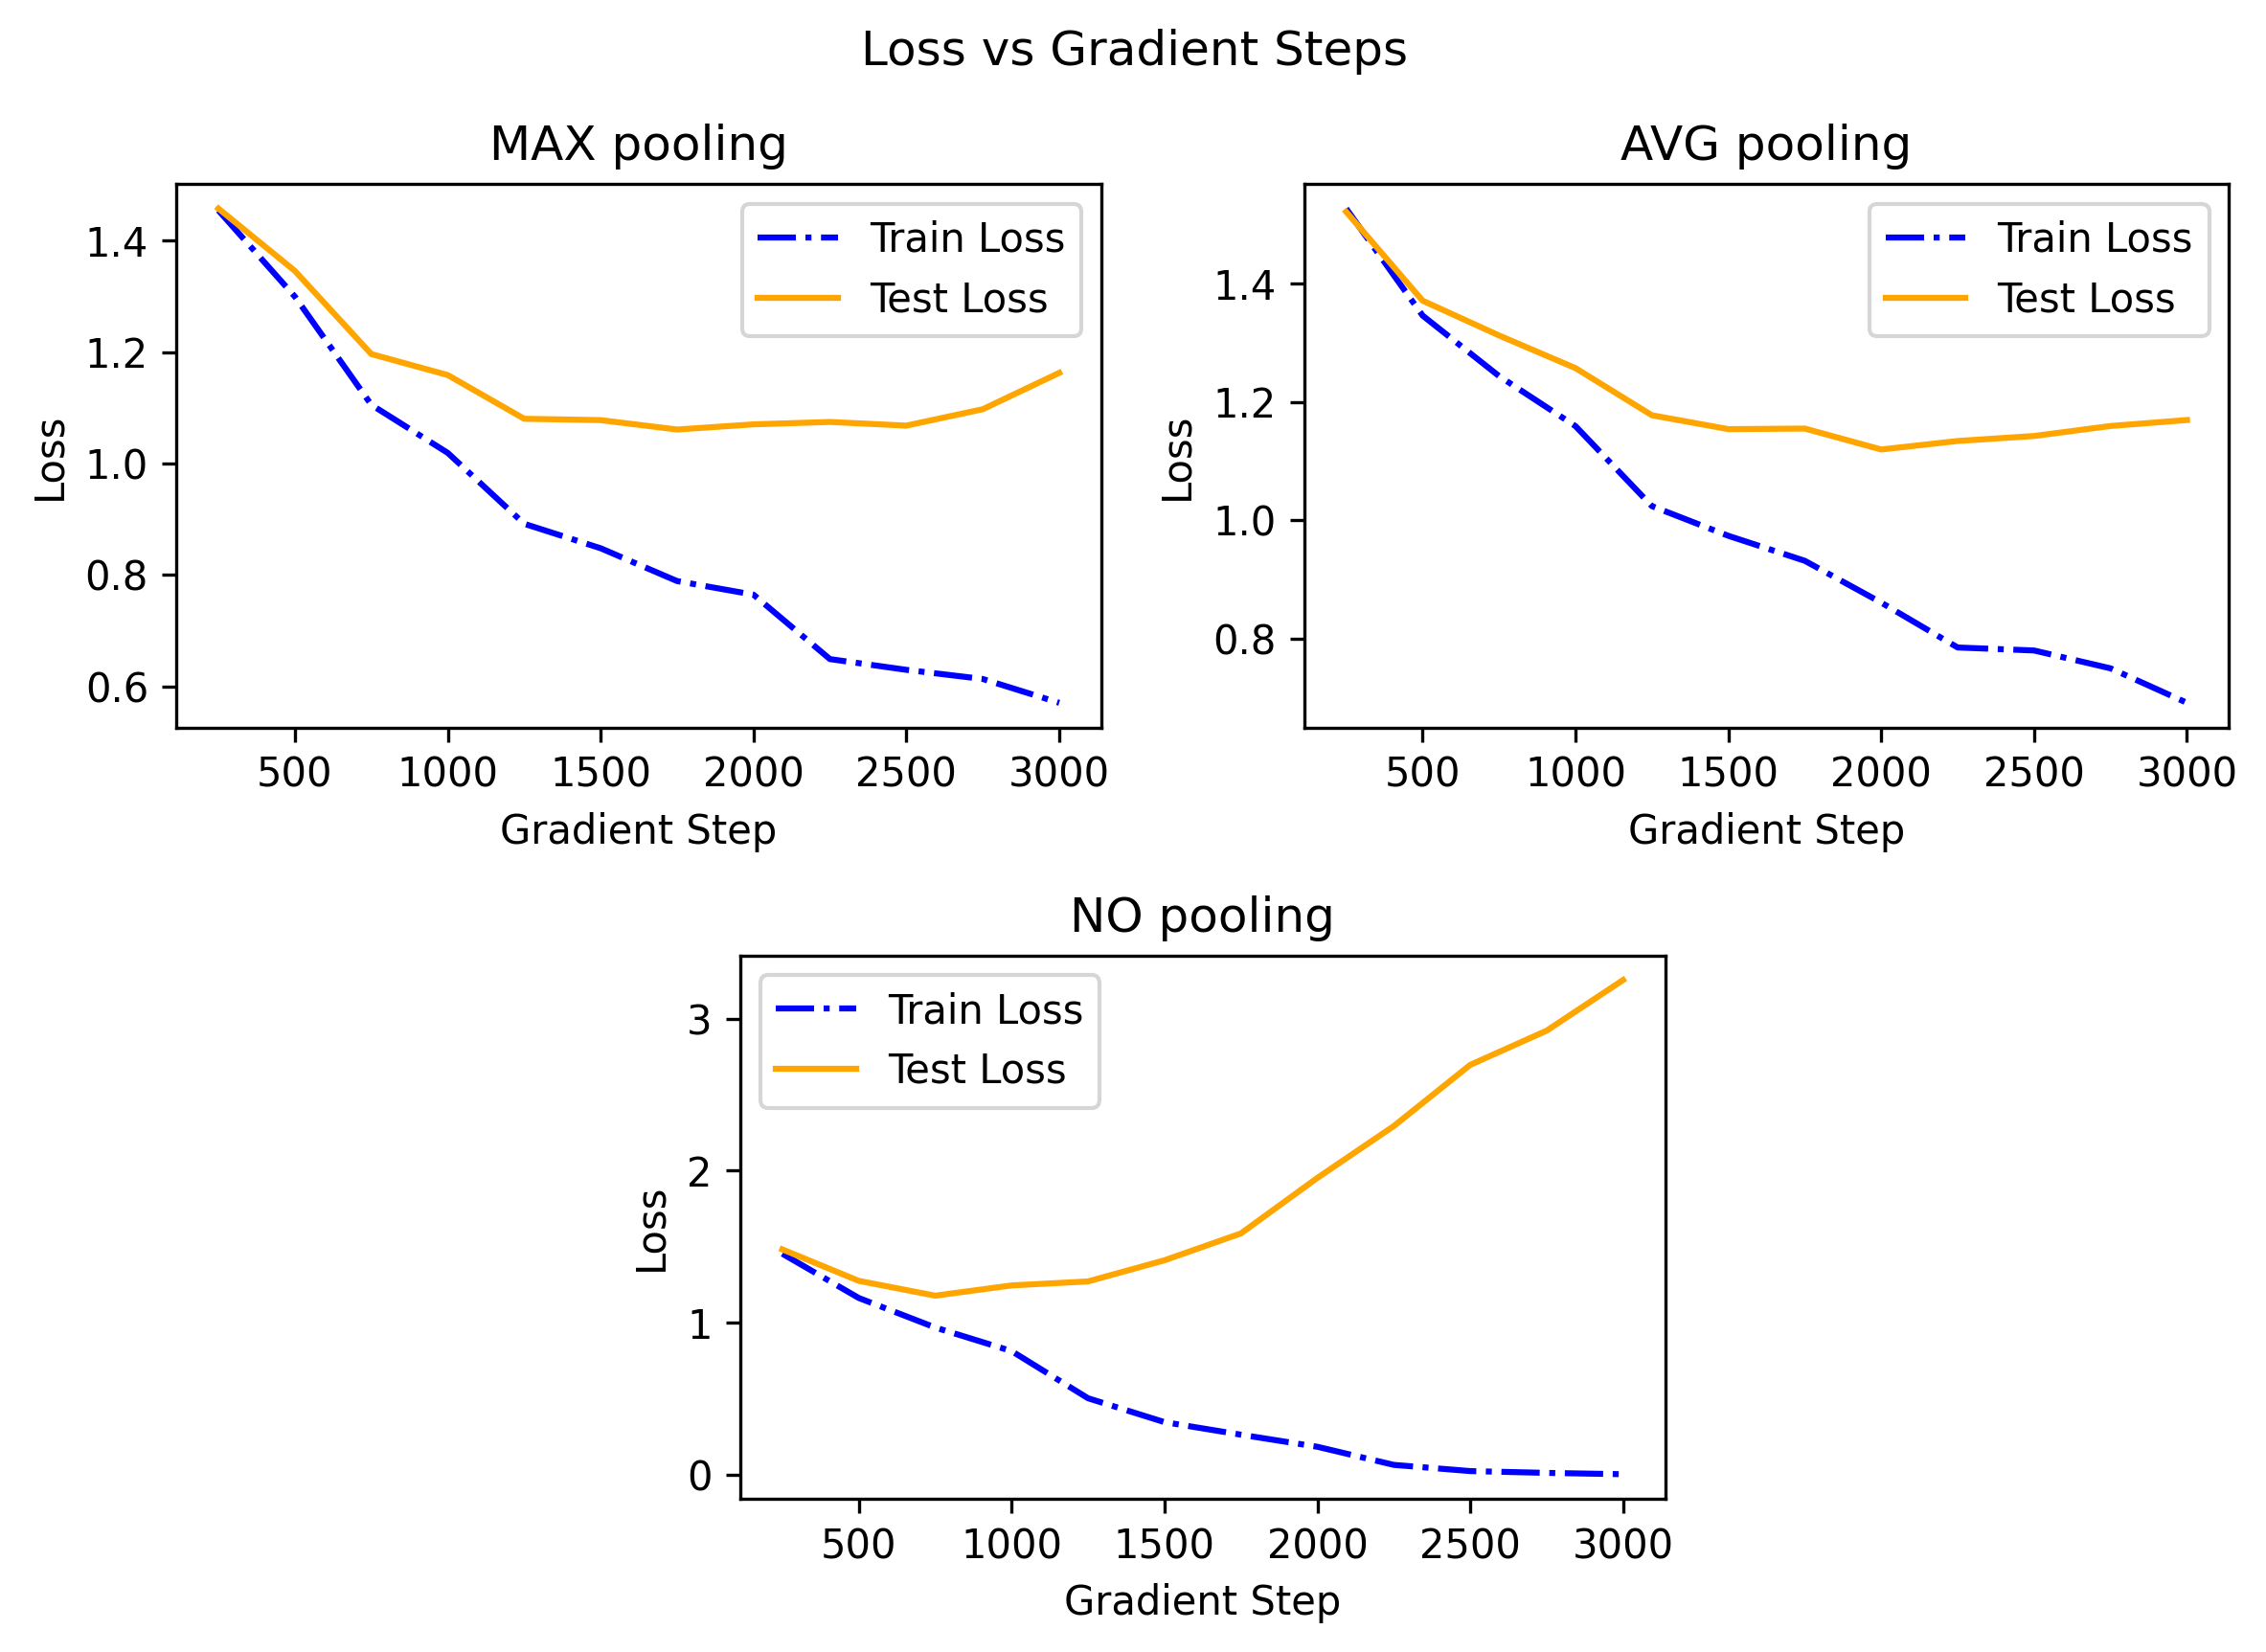

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

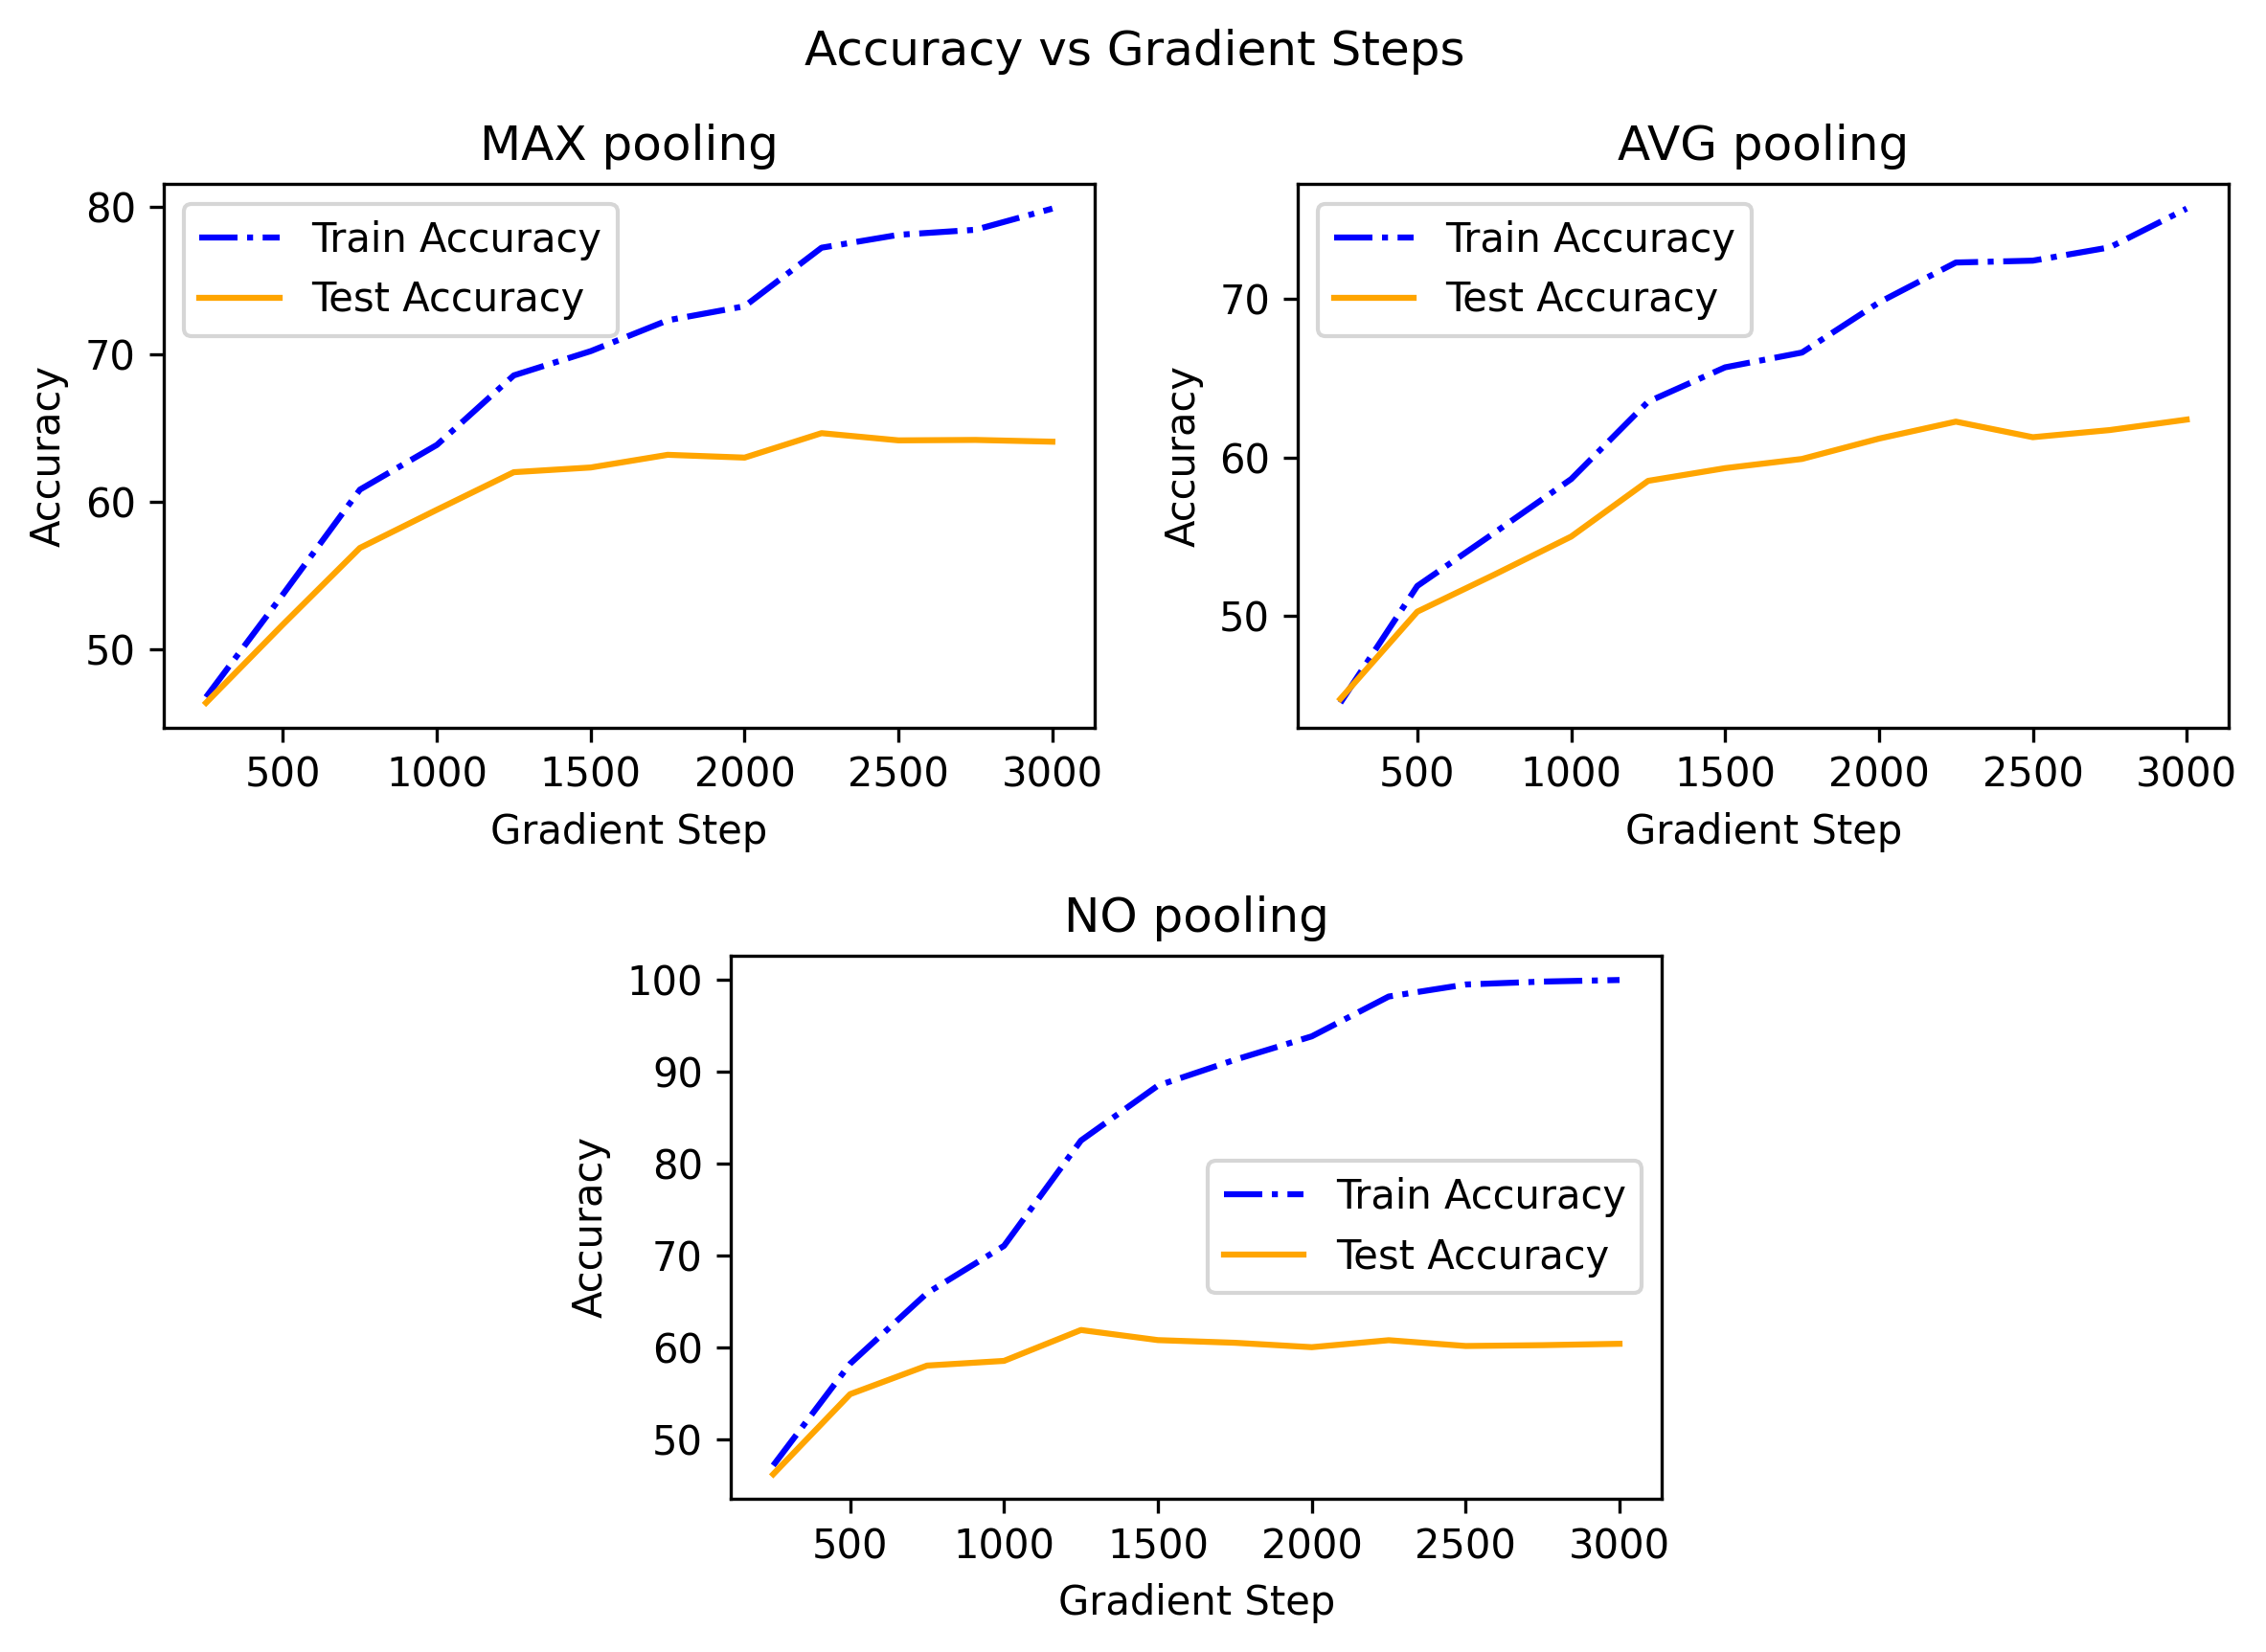

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
plot()

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from google.colab import files

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

# Function to plot the feature map visualizations for a given configuration of LeNet
def visualize(POOLING='avg'):
    with open(f'./results/visualize_{POOLING}.pkl', 'rb') as file:
        intermediates = pickle.load(file)
    
    idx = 0
    def visualize_images(out, out_name, nrows=2, ncols=3):
        nonlocal idx
        fig = plt.figure(idx, figsize=(ncols*2,nrows*2))
        for fig_idx in range(1, nrows*ncols+1):
            ax = fig.add_subplot(nrows, ncols, fig_idx)
            ax.imshow(out[fig_idx-1], interpolation='nearest')
            if out_name != 'input':
                ax.set_title(f'Channel {fig_idx}')
            ax.axis('off')
        plt.suptitle(f'Output Feature Maps of {out_name}' if out_name != 'input' else 'Input Image')
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.savefig(f'./plots/visualize_{out_name}.png')
        plt.show()
        files.download(f'./plots/visualize_{out_name}.png')
        idx += 1
    
    print(intermediates['label'])
    visualize_images(np.transpose(intermediates['input'].reshape((1, 3, 32, 32)), (0, 2, 3, 1)), 'input', 1, 1)
    visualize_images(intermediates['conv1'].reshape((-1, 28, 28)), 'conv1', 2, 3)
    visualize_images(intermediates['pool1'].reshape((-1, 14, 14)), 'pool1', 2, 3)

6


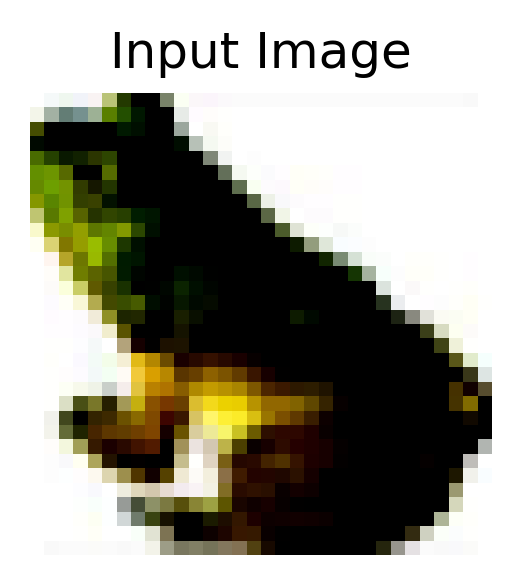

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

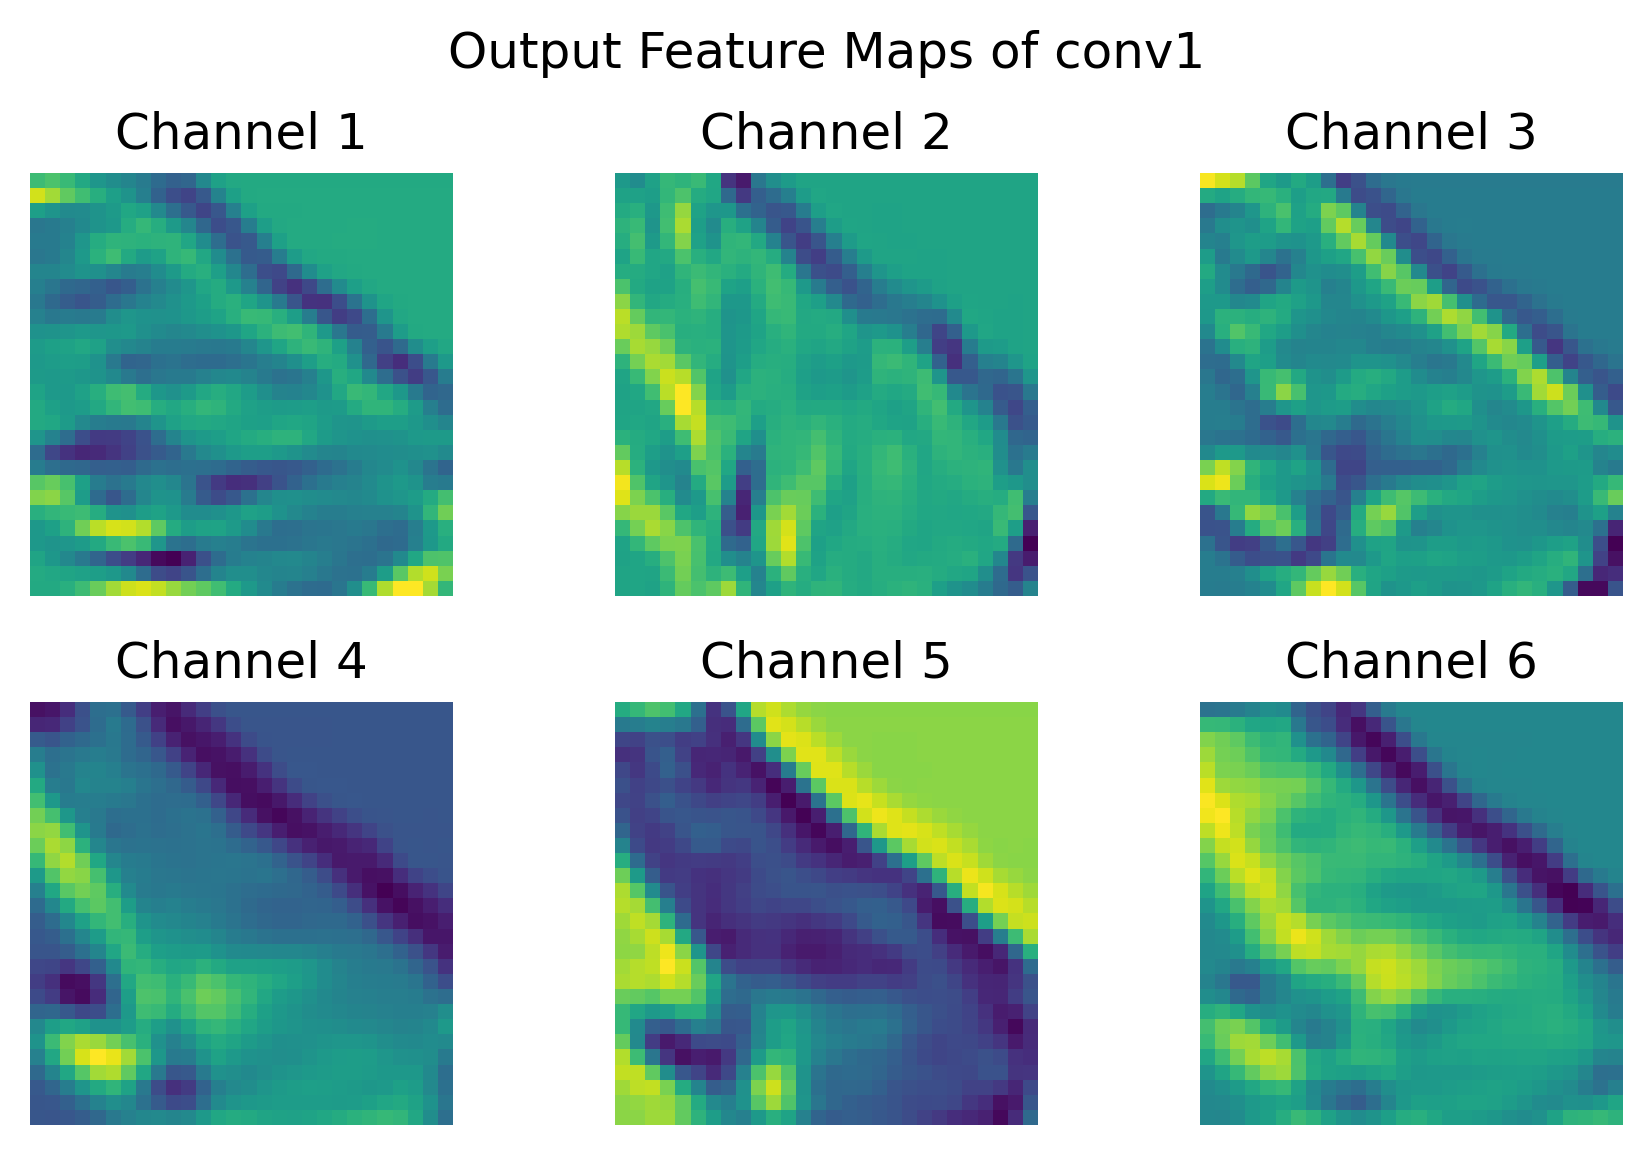

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

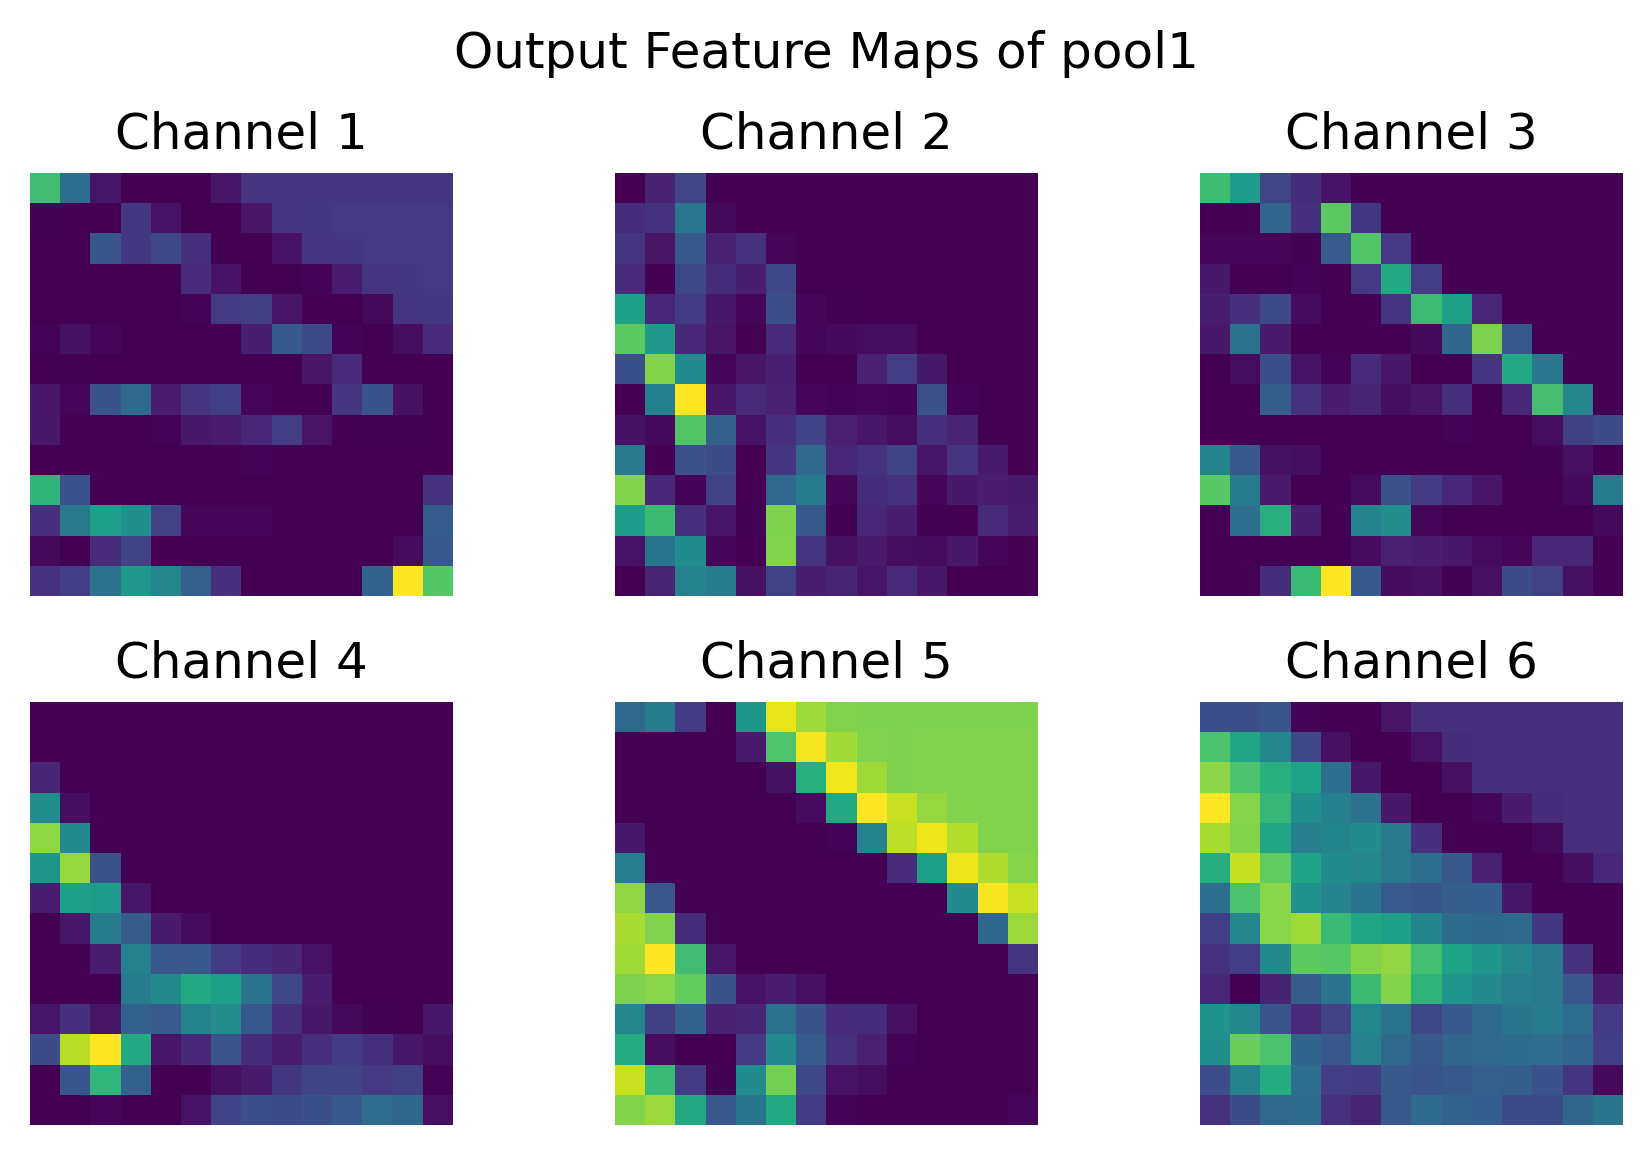

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
visualize('avg')